## Crear modelo de RL y RF

En este apartado cambiaremos nuestra capa densa por un modelo de Regeresión Logística, un Random Forest y un Gradient Boosting

In [1]:

import pickle

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from hypopt import GridSearch #para poder usar una muestra de validación y no CV

import pandas as pd

%matplotlib inline

In [2]:
with open("features_Xrays256_BW", "rb") as f:
    Xrays256_BW = pickle.load(f)
    pathology_list = pickle.load(f)
    binary_labels = pickle.load(f)
    multiclass_labels = pickle.load(f)
    cancer_labels = pickle.load(f)
    index_cancer = pickle.load(f)
    index_no_cancer = pickle.load(f)
    
with open("features_Xrays256_BW_2", "rb") as f:
    features_preentrenada = pickle.load(f)

In [3]:
test_size = int(np.shape(features_preentrenada)[0]*.20)
train_size = np.shape(features_preentrenada)[0]-test_size

In [4]:
X_train = features_preentrenada[:train_size]
y_train = cancer_labels[:train_size]

X_test = features_preentrenada[train_size:]
y_test = cancer_labels[train_size:]

In [5]:
#nval = 924
nval = 1000


X_tr = X_train[:-nval]
y_tr = y_train[:-nval]

X_va = X_train[-nval:]
y_va = y_train[-nval:]

#### Remuestreo Train

In [6]:
ind_cancer = np.where(y_tr==1)[0].flatten()
ind_no_cancer = np.where(y_tr!=1)[0].flatten()

In [7]:
np.shape(ind_no_cancer)[0]/ np.shape(ind_cancer)[0]

9.690184049079754

In [8]:
n_resample=8

In [9]:
indice_train = np.concatenate(( np.tile(ind_cancer,(n_resample,1)).flatten(), ind_no_cancer), axis=0, out=None)
np.shape(indice_train)

(5767,)

In [10]:
### desordenamos el índice, para que los registros no estén ordenados en el entrenamiento

np.random.shuffle(indice_train)
indice_train



array([ 757,  108, 1553, ..., 2256, 3315, 1763], dtype=int64)

In [11]:
np.shape(X_tr[indice_train])

(5767, 512)

In [12]:
X_tr=X_tr[indice_train]
y_tr=y_tr[indice_train]

#### Remuestreo Validación

In [13]:
ind_cancer_va = np.where(y_va==1)[0].flatten()
ind_no_cancer_va = np.where(y_va!=1)[0].flatten()
np.shape(ind_no_cancer_va)[0]/ np.shape(ind_cancer_va)[0]

7.849557522123894

In [14]:
n_resample_va=8

In [15]:
indice_va = np.concatenate(( np.tile(ind_cancer_va,(n_resample_va,1)).flatten(), ind_no_cancer_va), axis=0, out=None)
np.shape(indice_va)

(1791,)

In [16]:
### desordenamos el índice, para que los registros no estén ordenados en el entrenamiento

np.random.shuffle(indice_va)
indice_va

array([ 757,  108, 1553, ..., 2256, 3315, 1763], dtype=int64)

In [17]:
np.shape(X_va[indice_va])

(1791, 512)

In [18]:
X_va=X_va[indice_va]
y_va=y_va[indice_va]
y_va.sum()

904

In [19]:
print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)
print(X_test.shape, y_test.shape)

(5767, 512) (5767,)
(1791, 512) (1791,)
(1121, 512) (1121,)


Comprobamos balanceo

In [20]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_tr),
                                                 y_tr)

In [21]:
class_weights , class_weights[1]/class_weights[0] #con esto sabemos la proporción

(array([0.91278886, 1.1056365 ]), 1.2112730061349692)

### Regresión Logística con  Validación cruzada

In [23]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_tr)
X_tr_sc = sc.transform(X_tr)
X_va_sc = sc.transform(X_va)
X_test_sc = sc.transform(X_test)

In [25]:
np.random.randint(0,10e6, size=20)

array([8088866, 3838201, 5012128, 9267824,  629774, 8803496, 6966952,
       7004191, 6283162, 1943857, 8785647, 2743589, 4914000, 4971107,
       7659721, 8549108, 1251150, 8434627, 8824967, 9901960])

In [26]:

param_dist = { "C": np.random.randint(0, 10e6, size=20) }


logreg = LogisticRegression(random_state=0, solver='liblinear',penalty='l1', class_weight='balanced')

modelo_logit  = GridSearch(model = logreg,  param_grid=param_dist)

modelo_logit.fit(X_tr_sc, y_tr, X_va, y_va,scoring='roc_auc' )

#modelo_logit_CV = RandomizedSearchCV(logreg, param_distributions=param_dist, cv=10).fit(X_tr_sc, y_tr)


LogisticRegression(C=6950745, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [27]:
print("Score de Regresión Logística en test:", modelo_logit.score(X_test_sc, y_test))

Score de Regresión Logística en test: 0.7323818019625334


In [36]:
modelo_logit.best_estimator_

LogisticRegression(C=20737, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

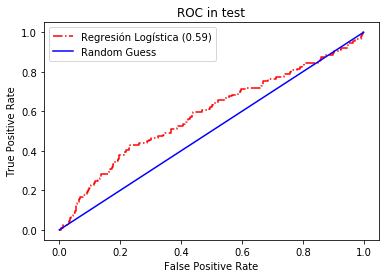

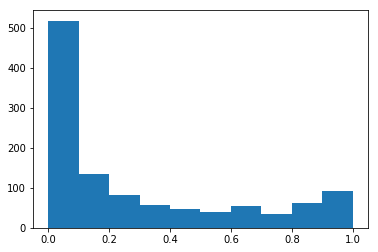

In [38]:
#y_pred_proba = LR_model.predict(X_test_sc)
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
y_pred_proba = modelo_logit.predict_proba(X_test_sc) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Regresión Logística (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC in test')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

plt.hist(y_pred_proba[:,1])
plt.show()

In [40]:
y_pred_proba = modelo_logit.predict(X_test)
print(classification_report(y_test, y_pred_proba))

             precision    recall  f1-score   support

          0       0.91      0.41      0.57      1007
          1       0.11      0.65      0.19       114

avg / total       0.83      0.44      0.53      1121



### Random Forest con  Validación cruzada

In [23]:
param_dist = {'max_depth': [10, None], 'max_features': np.random.randint(0, 200, size=5),
              'min_samples_split':np.random.randint(2, 50, size=5), 'n_estimators':np.random.randint(10, 110, size=5)}


RF = RandomForestClassifier( class_weight='balanced')
modelo_RF  = GridSearch(model = RF,  param_grid=param_dist)

modelo_RF.fit(X_tr_sc, y_tr, X_va, y_va,scoring='roc_auc' )
# modelo_RF_CV = RandomizedSearchCV(RF, param_distributions=param_dist, cv=10).fit(X_tr_sc, y_tr)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=33, min_weight_fraction_leaf=0.0,
            n_estimators=31, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [25]:
print("Score de Random Forest en test:", modelo_RF.score(X_test_sc, y_test))

Score de Random Forest en test: 0.856378233719893


In [26]:
modelo_RF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=33, min_weight_fraction_leaf=0.0,
            n_estimators=31, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

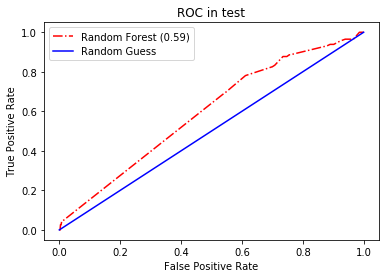

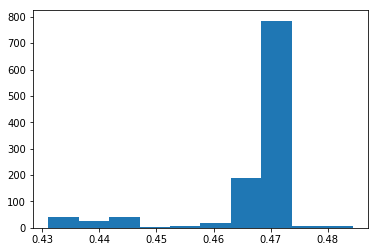

In [28]:
#y_pred_proba = RF_model.predict(X_test)
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
y_pred_proba = modelo_RF.predict_proba(X_test) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Random Forest (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC in test')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

plt.hist(y_pred_proba[:,1])
plt.show()

In [29]:
y_pred_proba = modelo_RF.predict(X_test)
print(classification_report(y_test, y_pred_proba))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95      1007
          1       0.00      0.00      0.00       114

avg / total       0.81      0.90      0.85      1121



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Gradient Boosting con  Validación cruzada

In [32]:
param_dist={'max_depth':np.random.randint(1, 10, size=5),
            'max_features':np.random.randint(1, 10, size=5),
            'min_samples_leaf' :np.random.randint(1, 10, size=5),
            'min_samples_split':np.random.randint(1, 10, size=5)}

GBC = GradientBoostingClassifier( n_estimators=100, random_state=0)

# GBC_model = RandomizedSearchCV(GBC, param_distributions=rf_p_dist,
#                                   n_jobs=-1, n_iter=10, cv=9)
# GBC_model.fit(X_tr_sc, y_tr)


GBC_model  = GridSearch(model = GBC,  param_grid=param_dist)

GBC_model.fit(X_tr_sc, y_tr, X_va, y_va,scoring='roc_auc' )

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=6,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [33]:
print("Score de GBC en test:", GBC_model.score(X_test_sc, y_test))

Score de GBC en test: 0.8947368421052632


In [34]:

GBC_model.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=6,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

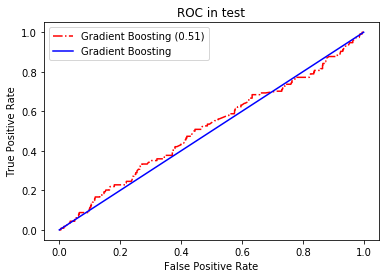

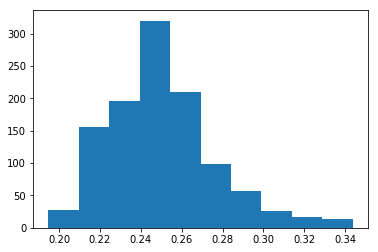

In [35]:
#y_pred_proba = RF_model.predict(X_test)
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
y_pred_proba = GBC_model.predict_proba(X_test) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Gradient Boosting (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC in test')
ax1.plot(fpr, fpr, 'b-', label = 'Gradient Boosting')
ax1.legend()
plt.show()

plt.hist(y_pred_proba[:,1])
plt.show()

In [36]:
y_pred_proba = GBC_model.predict(X_test)
print(classification_report(y_test, y_pred_proba))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95      1007
          1       0.00      0.00      0.00       114

avg / total       0.81      0.90      0.85      1121



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
np.random.randint(2, 50, size=5)

array([41, 25, 48, 26, 19])

In [45]:
np.arange(1,5)

array([1, 2, 3, 4])

In [51]:
np.linspace(1,5,5)

array([1., 2., 3., 4., 5.])